#MSTAR
This notebook shows how to load and view the [MSTAR data](https://www.sdms.afrl.af.mil/index.php?collection=mstar). The preprocessed data can be downloaded as below.

In [2]:
import urllib.request
import numpy as np
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
urllib.request.urlretrieve('http://www-users.math.umn.edu/~jwcalder/SAR10.npz','SAR10.npz')
M = np.load('SAR10.npz', allow_pickle=True)
hdr,fields,mag,phase = M['hdr'],M['fields'],M['mag'],M['phase']

hdr contains the header information for each image, and fields is the titles of the columns.

In [3]:
print('Header Shape:',hdr.shape)
print('Header fields:',fields)
print('Example header info:',hdr[0,:])

Header Shape: (6874, 7)
Header fields: ['TargetType' 'TargetSerNum' 'TargetAz' 'TargetRoll' 'TargetPitch'
 'TargetYaw' 'DesiredDepression']
Example header info: ['btr70_transport' 'c71' '27.006783' '-1.179039' '358.580475' '351.30838'
 '15']


mag contains all the magnitude images and phase all the phase images. The images are cropped to 88x88 pixels surrounding the object of interest in the center of the image.

In [4]:
print(mag.shape)
print(phase.shape)

(6874, 88, 88)
(6874, 88, 88)


There are 10 target types, which are the labels for classification.

In [5]:
np.unique(hdr[:,0])

array(['2s1_gun', 'bmp2_tank', 'brdm2_truck', 'btr60_transport',
       'btr70_transport', 'd7_bulldozer', 't62_tank', 't72_tank',
       'zil131_truck', 'zsu23-4_gun'], dtype=object)

The code below shows how to display some random images with their labels.

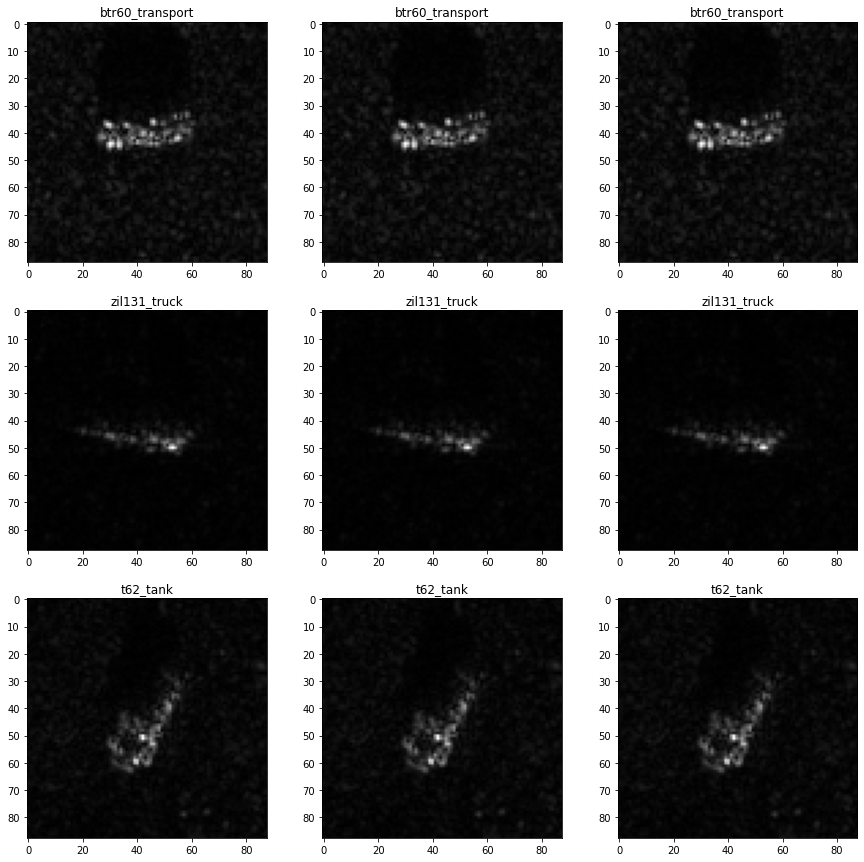

In [6]:
import matplotlib.pyplot as plt

numx,numy = 3,3
fig, axs = plt.subplots(numx,numy,figsize=(15,15))
n = mag.shape[0]
R = np.random.permutation(n)
for i in range(numx):
    for j in range(numy):
        img = mag[R[i],:,:]
        #img = img/np.max(img)
        #img = np.log(img + 1e-3)
        axs[i,j].imshow(img,cmap='gray')
        axs[i,j].set_title(hdr[R[i],0])
        #axs[i,j].axis('off')

#CNN Classifier
Here we explore a simple convolutional neural network for classification. We first define the network and train/test functions.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import datasets
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from scipy.special import softmax
import sys
import os

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        w = (32,64) #Number of channels in 1st and 2nd layers
        self.conv1 = nn.Conv2d(1, w[0], 3, 1)
        self.conv2 = nn.Conv2d(w[0], w[1], 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

        f = 512  #Number of hidden nodes in fully connected layers
        self.fc1 = nn.Linear(w[1]*10*10, f)
        self.fc2 = nn.Linear(f, 10)
        self.bn1 = nn.BatchNorm1d(f)

    def forward(self, x): #88
        x = self.conv1(x) #86 
        x = F.relu(x)
        x = F.max_pool2d(x, 2) #43
        x = self.conv2(x) #41
        x = F.relu(x)
        x = F.max_pool2d(x, 4)  #10
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn1(x)   #batch normalization
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

    #This is useful for extracting features from convolutional part of NN
    def convnet(self, x):
        x = self.conv1(x) #86 
        x = F.relu(x)
        x = F.max_pool2d(x, 2) #43
        x = self.conv2(x) #41
        x = F.relu(x)
        x = F.max_pool2d(x, 4)  #10
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        return x

def train(model, device, data_train, target_train, optimizer, epoch, batch_size):
    model.train()
    batch_idx = 0
    for idx in range(0,len(data_train),batch_size):
        data, target = data_train[idx:idx+batch_size], target_train[idx:idx+batch_size]
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == -1:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(target_train),
                100. * batch_idx / int(len(data_train)/batch_size), loss.item()))
        batch_idx += 1


def test(model, device, data_test, target_test,name):
    batch_size = 1000
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for idx in range(0,len(data_test),batch_size):
            data, target = data_test[idx:idx+batch_size], target_test[idx:idx+batch_size]
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(target_test)

    print(name+' set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, correct, len(target_test),
        100. * correct / len(target_test)))

We now preprocess the data: convert labels to integers, train/test split, converting to Torch, randomly shuffling traiing set.

In [8]:
#Convert targets to numerical labels
target = hdr[:,0].tolist()
classes = set(target)
label_dict = dict(zip(classes, np.arange(len(classes))))
labels = np.array([label_dict[t] for t in target],dtype=int)

#Training and testing split (based on papers)
angle = hdr[:,6].astype(int)
train_idx = angle == 17
test_idx = angle == 15

#Train testing split and convert to torch
data = torch.from_numpy(np.reshape(mag,(mag.shape[0],1,mag.shape[1],mag.shape[2]))).float()
labels = torch.from_numpy(labels).long()
data_train = data[train_idx,:,:,:]
data_test = data[test_idx,:,:,:]
target_train = labels[train_idx]
target_test = labels[test_idx]

#Randomly shuffle training data
P = torch.randperm(np.sum(train_idx))
data_train = data_train[P,:,:,:]
target_train = target_train[P]

Now we train the convolutional neural network.

In [9]:
#Training settings
cuda = True   #Use GPU acceleration (Edit->Notebook Settings and enable GPU)
batch_size = 150
learning_rate = 1    #Learning rate
gamma = 0.9     #Learning rate step
epochs = 50

#Cuda and optimizer/scheduler
use_cuda = cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

#Main training loop
for epoch in range(1, epochs + 1):
    train(model, device, data_train, target_train, optimizer, epoch, batch_size)
    print('\nEpoch: %d'%epoch)
    test(model, device, data_test, target_test, 'Test ')
    test(model, device, data_train, target_train, 'Train')
    scheduler.step()

#Save model
torch.save(model.state_dict(), 'SAR10_cnn.pt')

#Save encoded data
model.eval()
with torch.no_grad():
    Y = model.convnet(data.to(device)).cpu().numpy()  
    np.savez_compressed('SAR10_cnn.npz',data=Y,labels=labels.numpy())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Epoch: 1
Test  set: Average loss: 1.6831, Accuracy: 1234/3203 (38.53%)
Train set: Average loss: 1.5373, Accuracy: 1660/3671 (45.22%)

Epoch: 2
Test  set: Average loss: 1.6386, Accuracy: 1637/3203 (51.11%)
Train set: Average loss: 1.1315, Accuracy: 2172/3671 (59.17%)

Epoch: 3
Test  set: Average loss: 0.7419, Accuracy: 2396/3203 (74.80%)
Train set: Average loss: 0.2118, Accuracy: 3463/3671 (94.33%)

Epoch: 4
Test  set: Average loss: 0.4439, Accuracy: 2732/3203 (85.30%)
Train set: Average loss: 0.3666, Accuracy: 3205/3671 (87.31%)

Epoch: 5
Test  set: Average loss: 0.2155, Accuracy: 2992/3203 (93.41%)
Train set: Average loss: 0.0549, Accuracy: 3645/3671 (99.29%)

Epoch: 6
Test  set: Average loss: 0.1874, Accuracy: 3002/3203 (93.72%)
Train set: Average loss: 0.0250, Accuracy: 3665/3671 (99.84%)

Epoch: 7
Test  set: Average loss: 0.1387, Accuracy: 3079/3203 (96.13%)
Train set: Average loss: 0.0176, Accuracy: 3667/3671 (99.89%)

Epoch: 8
Test  set: Average loss: 0.1715, Accuracy: 3033/3203

#Active learning methods
We explored the use of random sampling, uncertainty sampling, V-Optimality, Model Change, as well as MC-VOpt

In [10]:
#Function to randomly select points from each class and perform laplace and poisson learning
def initial_run(W, labels, num_train_per_class, random_state, plot=False):
  #Initialize training points
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  np.random.seed(random_state)
  train_ind = gl.randomize_labels(labels,num_train_per_class)
  np.random.seed()
  print("%f%% training data"%(100*len(train_ind)/num_pts))

  #Laplace Learning
  u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
  labels_laplace = np.argmax(u_laplace, axis=1)
  laplace_acc = gl.accuracy(labels[test_idx], labels_laplace[test_idx], len(train_ind))

  #Poisson Learning
  u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)
  labels_poisson = np.argmax(u_poisson, axis=1)
  poisson_acc = gl.accuracy(labels, labels_poisson, len(train_ind))

  #Output results
  # if plot is True: 
  #   scatterplot(data, labels, train_ind, []) 
  #   laplace_poisson(data, labels_laplace, labels_poisson)
  print('Number of Labels,Accuracy')
  print('Laplace: %d,%.3f'%(len(train_ind),laplace_acc))
  print('Poisson: %d,%.3f'%(len(train_ind),poisson_acc))

  return train_ind, laplace_acc, poisson_acc, u_laplace, u_poisson

In [11]:
#Function to perform simulation using random sampling
def random_simulation(W, labels, num_train_per_class, num_labels, random_state=0, plot=False):
  print("Random Sampling")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, laplace_acc, poisson_acc, u_laplace, u_poisson = initial_run(W, labels, num_train_per_class, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  laplace = np.array([laplace_acc])
  poisson = np.array([poisson_acc])

  #loop for adding new labeled datapoints
  for i in range(num_labels-len(train_ind)):
    obj_values = np.ones(num_pts)
    obj_values[train_ind] = 0
    obj_values = obj_values/np.sum(obj_values)
    new_train_ind = np.random.choice(num_pts, size=1, replace=False, p=obj_values)
    train_ind = np.append(train_ind,new_train_ind)
    
    #Laplace Learning
    u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
    labels_laplace = np.argmax(u_laplace, axis=1)
    laplace_acc = gl.accuracy(labels, labels_laplace, len(train_ind))

    #Poisson Learning
    u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)
    labels_poisson = np.argmax(u_poisson, axis=1)
    poisson_acc = gl.accuracy(labels, labels_poisson, len(train_ind))

    #Output results
    # if plot is True: 
    #   scatterplot(data, labels, train_ind, obj_values) 
    #   laplace_poisson(data, labels_laplace, labels_poisson) 
    print(obj_values.min(), obj_values.max())
    print('Number of Labels,Accuracy')
    print('Laplace: %d,%.3f'%(len(train_ind),laplace_acc))
    print('Poisson: %d,%.3f'%(len(train_ind),poisson_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    laplace = np.append(laplace, laplace_acc)
    poisson = np.append(poisson, poisson_acc)
  print()

  return num_train, laplace, poisson

In [12]:
def stats(uncertainty_values, filename):
  mean = np.mean(uncertainty_values)
  std = np.std(uncertainty_values)
  quantile1 = np.quantile(uncertainty_values, 0.25)
  median = np.quantile(uncertainty_values, 0.5)
  quantile3 = np.quantile(uncertainty_values, 0.75)
  min = np.min(uncertainty_values)
  max = np.max(uncertainty_values)
  with open('%s.csv'%filename, 'a') as f:
    f.writelines(f"mean=%.3f, std=%.3f, quantiles=(%.3f, %.3f, %.3f, %.3f, %.3f)"%(mean,std,min,quantile1,median,quantile3,max)+'\n')

def uncertainty(u, labeled_ind=None):
    num_pts = u.shape[0]
    num_classes = u.shape[1]
    u_probs = softmax(u, axis=1) 
    one_hot_predicted_labels = np.eye(num_classes)[np.argmax(u, axis=1)]
    obj_values = np.linalg.norm((u_probs - one_hot_predicted_labels), axis=1)
    if labeled_ind is None:
        return obj_values
    else:
        obj_values[labeled_ind] = obj_values.min()
    return obj_values

#Function to perform simulation using uncertainty sampling
def uncertainty_simulation(W, labels, num_train_per_class, num_labels, random_state=0, plot=False):
  print("Uncertainty Sampling")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, laplace_acc, poisson_acc, u_laplace, u_poisson = initial_run(W, labels, num_train_per_class, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  laplace = np.array([laplace_acc])
  poisson = np.array([poisson_acc])

  #loop for adding new labeled datapoints
  for i in range(num_labels-len(train_ind)):
    obj_values = uncertainty(u_laplace, train_ind)
    stats(obj_values, 'uncertainty_sampling')
    new_train_ind = np.argmax(obj_values)
    train_ind = np.append(train_ind,new_train_ind)
    
    #Laplace Learning
    u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
    labels_laplace = np.argmax(u_laplace, axis=1)
    laplace_acc = gl.accuracy(labels, labels_laplace, len(train_ind))

    #Poisson Learning
    u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)
    labels_poisson = np.argmax(u_poisson, axis=1)
    poisson_acc = gl.accuracy(labels, labels_poisson, len(train_ind))

    #Output results
    if plot is True: 
      scatterplot(data, labels, train_ind, obj_values) 
      laplace_poisson(data, labels_laplace, labels_poisson) 
    print(obj_values.min(), obj_values.max())
    print('Number of Labels,Accuracy')
    print('Laplace: %d,%.3f'%(len(train_ind),laplace_acc))
    print('Poisson: %d,%.3f'%(len(train_ind),poisson_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    laplace = np.append(laplace, laplace_acc)
    poisson = np.append(poisson, poisson_acc)
  print()

  return num_train, laplace, poisson

In [13]:
#Function to initialize covariance matrix
def init_c(evals, evecs, labeled_ind=None):
    # do not include evals that are very close to 0!
    K = (evecs/evals[np.newaxis, :]) @ evecs.T
    if labeled_ind is None:
      return K
    else:  
      unlabeled_ind = list(filter(lambda x: x not in labeled_ind, range(evecs.shape[0])))
      return K[np.ix_(unlabeled_ind, unlabeled_ind)] - K[np.ix_(unlabeled_ind, labeled_ind)] @ linalg.inv(K[np.ix_(labeled_ind, labeled_ind)]) \
                                                              @ K[np.ix_(labeled_ind, unlabeled_ind)]
  
#Function to update the covariance matrix
def update_c(C, max_idx, labeled_ind):
    unlabeled_ind = np.delete(np.arange(C.shape[0]+len(labeled_ind)), labeled_ind)
    k = np.where(unlabeled_ind == max_idx)[0][0]
    C -= np.outer(C[:,k], C[:,k])/C[k,k]
    not_k = np.delete(np.arange(C.shape[0]), k)

    return C[np.ix_(not_k, not_k)]

#Function to calculate v-opt objective function values
def v_opt(C, labeled_ind=None):
  unl_values = np.array([np.linalg.norm(C[i])**2/C[i,i] for i in range(C.shape[0])])
  if labeled_ind is None:
    return unl_values
  else:
    num_pts = C.shape[0] + len(labeled_ind)
    obj_values = np.ones(num_pts)*unl_values.min() 
    unlabeled_ind = np.delete(np.arange(num_pts), labeled_ind)
    obj_values[unlabeled_ind] = unl_values
    return obj_values

#Function to perform simulation using uncertainty sampling
def vopt_simulation(W, labels, num_train_per_class, num_labels, random_state=0, plot=False):
  print("V-Optimality")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, laplace_acc, poisson_acc, u_laplace, u_poisson = initial_run(W, labels, num_train_per_class, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  laplace = np.array([laplace_acc])
  poisson = np.array([poisson_acc])

  #Formulations
  L=gl.graph_laplacian(W) #construct the graph laplacian
  k=int(.05*W.shape[0]) #number of eigenvalues/vectors
  vals, X = sparse.linalg.eigs(L,k=k, which='SM')
  X = X.real  
  vals = vals.real
  vals[0] = 0
  C = init_c(vals+1e-4, X, train_ind) #initialize cov matrix

  #loop for adding new labeled datapoints
  for i in range(num_labels-len(train_ind)):
    obj_values = v_opt(C, train_ind)
    new_train_ind = np.argmax(obj_values)
    C = update_c(C, new_train_ind, train_ind) #update cov matrix
    train_ind = np.append(train_ind,new_train_ind)
    
    #Laplace Learning
    u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
    labels_laplace = np.argmax(u_laplace, axis=1)
    laplace_acc = gl.accuracy(labels, labels_laplace, len(train_ind))

    #Poisson Learning
    u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)
    labels_poisson = np.argmax(u_poisson, axis=1)
    poisson_acc = gl.accuracy(labels, labels_poisson, len(train_ind))

    #Output results
    # if plot is True: 
    #   scatterplot(data, labels, train_ind, obj_values) 
    #   laplace_poisson(data, labels_laplace, labels_poisson) 
    print(obj_values.min(), obj_values.max()) 
    print('Number of Labels,Accuracy')
    print('Laplace: %d,%.3f'%(len(train_ind),laplace_acc))
    print('Poisson: %d,%.3f'%(len(train_ind),poisson_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    laplace = np.append(laplace, laplace_acc)
    poisson = np.append(poisson, poisson_acc)
  print()

  return num_train, laplace, poisson

In [14]:
#Function to calculate sigma-opt objective function values
def sigma_opt(C, labeled_ind=None):
  unl_values = np.array([np.sum(C[i])**2/C[i,i] for i in range(C.shape[0])])
  if labeled_ind is None:
    return unl_values
  else:
    num_pts = C.shape[0] + len(labeled_ind)
    obj_values = np.ones(num_pts)*unl_values.min() 
    unlabeled_ind = np.delete(np.arange(num_pts), labeled_ind)
    obj_values[unlabeled_ind] = unl_values
    return obj_values

#Function to perform simulation using uncertainty sampling
def sigmaopt_simulation(W, labels, num_train_per_class, num_labels, random_state=0, plot=False):
  print("Sigma-Optimality")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, laplace_acc, poisson_acc, u_laplace, u_poisson = initial_run(W, labels, num_train_per_class, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  laplace = np.array([laplace_acc])
  poisson = np.array([poisson_acc])

  #Formulations
  L=gl.graph_laplacian(W) #construct the graph laplacian
  k=int(.05*W.shape[0]) #number of eigenvalues/vectors
  vals, X = sparse.linalg.eigs(L,k=k, which='SM')
  X = X.real  
  vals = vals.real
  vals[0] = 0
  C = init_c(vals+1e-4, X, train_ind) #initialize cov matrix

  #loop for adding new labeled datapoints
  for i in range(num_labels-len(train_ind)):
    obj_values = sigma_opt(C, train_ind) 
    new_train_ind = np.argmax(obj_values)
    C = update_c(C, new_train_ind, train_ind) #update cov matrix
    train_ind = np.append(train_ind,new_train_ind)
    
    #Laplace Learning
    u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
    labels_laplace = np.argmax(u_laplace, axis=1)
    laplace_acc = gl.accuracy(labels, labels_laplace, len(train_ind))

    #Poisson Learning
    u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)
    labels_poisson = np.argmax(u_poisson, axis=1)
    poisson_acc = gl.accuracy(labels, labels_poisson, len(train_ind))

    #Output results
    # if plot is True: 
    #   scatterplot(data, labels, train_ind, obj_values) 
    #   laplace_poisson(data, labels_laplace, labels_poisson)
    print(obj_values.min(), obj_values.max()) 
    print('Number of Labels,Accuracy')
    print('Laplace: %d,%.3f'%(len(train_ind),laplace_acc))
    print('Poisson: %d,%.3f'%(len(train_ind),poisson_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    laplace = np.append(laplace, laplace_acc)
    poisson = np.append(poisson, poisson_acc)
  print()

  return num_train, laplace, poisson

In [15]:
#Function to calculate MC-VOpt objective function values
def mc_vopt(C, u, labeled_ind=[]):
  num_pts = C.shape[0] + len(labeled_ind)
  unlabeled_ind = np.delete(np.arange(num_pts), labeled_ind)
  uncertainty_terms = uncertainty(u)[unlabeled_ind]
  unl_values = np.array([np.linalg.norm(C[i])**2/C[i,i] for i in range(C.shape[0])])*uncertainty_terms
  if labeled_ind is []:
    return unl_values, uncertainty_terms
  else:
    obj_values = np.ones(num_pts)*unl_values.min() 
    obj_values[unlabeled_ind] = unl_values
    return obj_values, uncertainty_terms

#Function to perform simulation using uncertainty sampling
def mc_vopt_simulation(W, labels, num_train_per_class, num_labels, random_state=0, plot=False):
  print("MC-VOptimality")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, laplace_acc, poisson_acc, u_laplace, u_poisson = initial_run(W, labels, num_train_per_class, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  laplace = np.array([laplace_acc])
  poisson = np.array([poisson_acc])

  #Formulations
  L=gl.graph_laplacian(W) #construct the graph laplacian
  k=int(.05*W.shape[0]) #number of eigenvalues/vectors
  vals, X = sparse.linalg.eigs(L,k=k, which='SM')
  X = X.real  
  vals = vals.real
  vals[0] = 0
  C = init_c(vals+1e-4, X, train_ind) #initialize cov matrix

  #loop for adding new labeled datapoints
  for i in range(num_labels-len(train_ind)):
    obj_values, unc_values = mc_vopt(C, u_laplace, train_ind)
    stats(unc_values, 'mc_vopt') 
    new_train_ind = np.argmax(obj_values)
    C = update_c(C, new_train_ind, train_ind) #update cov matrix
    train_ind = np.append(train_ind,new_train_ind)
    
    #Laplace Learning
    u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
    labels_laplace = np.argmax(u_laplace, axis=1)
    laplace_acc = gl.accuracy(labels, labels_laplace, len(train_ind))

    #Poisson Learning
    u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)
    labels_poisson = np.argmax(u_poisson, axis=1)
    poisson_acc = gl.accuracy(labels, labels_poisson, len(train_ind))

    #Output results
    if plot is True: 
      scatterplot(data, labels, train_ind, obj_values) 
      laplace_poisson(data, labels_laplace, labels_poisson) 
    print(obj_values.min(), obj_values.max())
    print('Number of Labels,Accuracy')
    print('Laplace: %d,%.3f'%(len(train_ind),laplace_acc))
    print('Poisson: %d,%.3f'%(len(train_ind),poisson_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    laplace = np.append(laplace, laplace_acc)
    poisson = np.append(poisson, poisson_acc)
  print()

  return num_train, laplace, poisson

In [16]:
#Function to calculate MC-VOpt objective function values
def model_change(C, u, labeled_ind=[]):
  num_pts = C.shape[0] + len(labeled_ind)
  unlabeled_ind = np.delete(np.arange(num_pts), labeled_ind)
  uncertainty_terms = uncertainty(u)[unlabeled_ind]
  unl_values = np.array([np.linalg.norm(C[i])/C[i,i] for i in range(C.shape[0])])*uncertainty_terms
  if labeled_ind is []:
    return unl_values, uncertainty_terms
  else:
    obj_values = np.ones(num_pts)*unl_values.min() 
    obj_values[unlabeled_ind] = unl_values
    return obj_values, uncertainty_terms

#Function to perform simulation using uncertainty sampling
def mc_simulation(W, labels, num_train_per_class, num_labels, random_state=0, plot=False):
  print("MC-Laplace")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, laplace_acc, poisson_acc, u_laplace, u_poisson = initial_run(W, labels, num_train_per_class, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  laplace = np.array([laplace_acc])
  poisson = np.array([poisson_acc])

  #Formulations
  L=gl.graph_laplacian(W) #construct the graph laplacian
  k=int(.05*W.shape[0]) #number of eigenvalues/vectors
  vals, X = sparse.linalg.eigs(L,k=k, which='SM')
  X = X.real  
  vals = vals.real
  vals[0] = 0
  C = init_c(vals+1e-4, X, train_ind) #initialize cov matrix

  #loop for adding new labeled datapoints
  for i in range(num_labels-len(train_ind)):
    obj_values, unc_values = model_change(C, u_laplace, train_ind) 
    stats(unc_values, 'mc_laplace')
    new_train_ind = np.argmax(obj_values)
    C = update_c(C, new_train_ind, train_ind) #update cov matrix
    train_ind = np.append(train_ind,new_train_ind)
    
    #Laplace Learning
    u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
    labels_laplace = np.argmax(u_laplace, axis=1)
    laplace_acc = gl.accuracy(labels, labels_laplace, len(train_ind))

    #Poisson Learning
    u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)
    labels_poisson = np.argmax(u_poisson, axis=1)
    poisson_acc = gl.accuracy(labels, labels_poisson, len(train_ind))

    #Output results
    if plot is True: 
      scatterplot(data, labels, train_ind, obj_values) 
      laplace_poisson(data, labels_laplace, labels_poisson) 
    print(obj_values.min(), obj_values.max())
    print('Number of Labels,Accuracy')
    print('Laplace: %d,%.3f'%(len(train_ind),laplace_acc))
    print('Poisson: %d,%.3f'%(len(train_ind),poisson_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    laplace = np.append(laplace, laplace_acc)
    poisson = np.append(poisson, poisson_acc)
  print()

  return num_train, laplace, poisson

In [17]:
#Function to plot the laplace and poisson accuracy
def lineplot(num_train, random_acc, uncertainty_acc, vopt_acc, sigmaopt_acc, mcvopt_acc, method, filename=None):
  plt.figure(figsize=(16,8))
  plt.plot(num_train, vopt_acc, 'bv-', markersize=10, label='V-Opt')
  plt.plot(num_train, sigmaopt_acc, 'rs-', markersize=10, label='Sigma-Opt')
  plt.plot(num_train, random_acc, 'gx-', markersize=10, label='Random')
  plt.plot(num_train, uncertainty_acc, 'c+-', markersize=10, label='Uncertainty')
  plt.plot(num_train, mcvopt_acc, 'k*-', markersize=10, label='MC-VOpt')
  plt.xlabel('number of labeled points')
  plt.ylabel('%s Learning Accuracy'%method)
  plt.legend()
  if filename is not None: plt.savefig('%s.png'%filename)
  plt.show()
  print("rand: %.3f"%random_acc.max(), "unc: %.3f"%uncertainty_acc.max(), "vopt: %.3f"%vopt_acc.max(), "sopt: %.3f"%sigmaopt_acc.max(), "mc-vopt: %.3f"%mcvopt_acc.max())

#Graph learning
As a simple first step, we can apply graph-based learning to the CNN encoded features.

In [18]:
pip install -q graphlearning

     |████████████████████████████████| 49 kB 3.9 MB/s 
     |████████████████████████████████| 646 kB 13.6 MB/s 
     |████████████████████████████████| 93 kB 1.7 MB/s 


In [19]:
## Import useful packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.image import extract_patches_2d
from scipy.ndimage import gaussian_filter
import graphlearning as gl
from scipy import sparse, linalg
from sklearn.cluster import KMeans
from scipy.special import softmax
from sklearn.decomposition import PCA as sklearn_pca
import urllib.request
import scipy.io

In [20]:
## Function to generate the weight matrix
def weight_matrix(data):
  boolean = False
  k=1
  I,J,D = gl.knnsearch_annoy(data, 50, similarity='angular')
  D[D==0] = 1e-150

  while boolean==False:
    k+=1
    W = gl.weight_matrix(I,J,D,k)
    boolean = gl.isconnected(W)
    print("k=%d"%k, "connected=%s"%boolean)

  k=2*k
  W = gl.weight_matrix(I,J,D,k)
  print("k=%d"%k, "connected=%s"%boolean)
  print("weight matrix shape: ", W.shape)
  
  return W

In [21]:
#Function to perform PCA on image
def PCA(data, component=False):

  #Perform PCA with 1200 components
  pca = sklearn_pca(n_components=1200)
  pca.fit(data)
  variance = 100*(pca.explained_variance_ratio_)

  #Get the number of components with variance greater than 0.005%
  num_components = len(variance[variance>5e-3])

  #Perform PCA with the new number of components
  pca = sklearn_pca(n_components=num_components)
  pca_data = pca.fit_transform(data)
  print("Total Variation (%d components): "%num_components, np.sum(pca.explained_variance_ratio_))
  print("shape:",pca_data.shape)
  
  if component==True:
    return pca_data, num_components
  return pca_data

In [22]:
M = np.load('SAR10_cnn.npz')
X = M['data']   #Encoded data
labels = M['labels'] #Labels

print(X.shape)
print(labels.shape)
print(X)
print(labels)

(6874, 6400)
(6874,)
[[0.00805435 0.         0.0087653  ... 0.01749249 0.         0.00250503]
 [0.03458532 0.02280198 0.04583827 ... 0.03673116 0.         0.0127544 ]
 [0.02407824 0.0088147  0.         ... 0.02484003 0.02057817 0.01144449]
 ...
 [0.07096317 0.06143539 0.06101168 ... 0.         0.         0.03114731]
 [0.04598962 0.05013502 0.04762901 ... 0.02495009 0.02381272 0.00015271]
 [0.02761284 0.04939562 0.05777353 ... 0.04515871 0.00092354 0.02177017]]
[2 2 2 ... 6 6 6]


kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
k=2 connected=False
k=3 connected=False
k=4 connected=False
k=5 connected=False
k=6 connected=False
k=7 connected=False
k=8 connected=False
k=9 connected=False
k=10 connected=False
k=11 connected=False
k=12 connected=False
k=13 connected=True
k=26 connected=True
weight matrix shape:  (6874, 6874)
Sigma-Optimality
0.145476% training data
Number of Labels,Accuracy
Laplace: 10,38.960
Poisson: 10,33.508
0.03689675450525566 724576.8551032963
Number of Labels,Accuracy
Laplace: 11,31.925
Poisson: 11,33.979
0.02372555923256182 240683.57236229288
Number of Labels,Accuracy
Laplace: 12,36.724
Poisson: 12,30.662
0.0008938371878210727 145030.17212781656
Number of Labels,Accuracy
Laplace: 13,32.138
Poisson: 13,32.663
0.0008082767161902323 108415.96495138947
Number of Labels,Accuracy
Laplace: 14,35.685
Poisson: 14,32.945
0.06943708028158786 87044.00770643733
Num

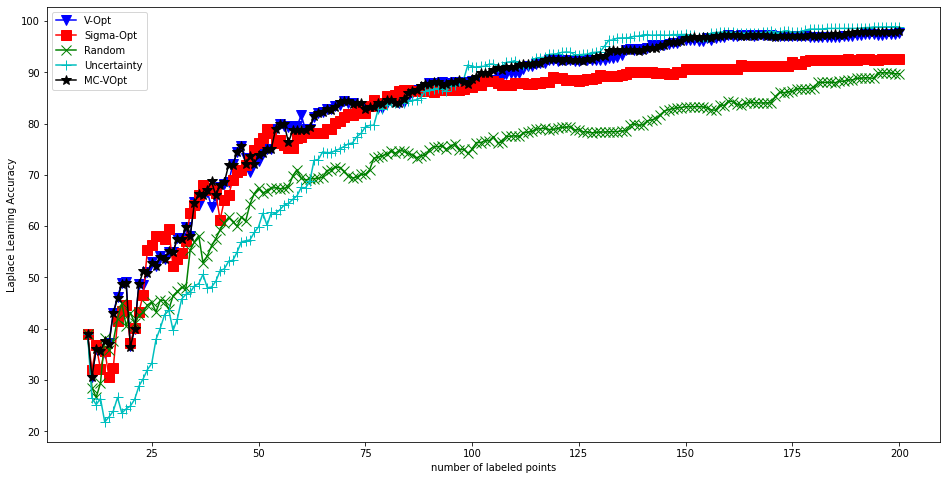

rand: 89.954 unc: 98.921 vopt: 97.708 sopt: 92.658 mc-vopt: 97.992


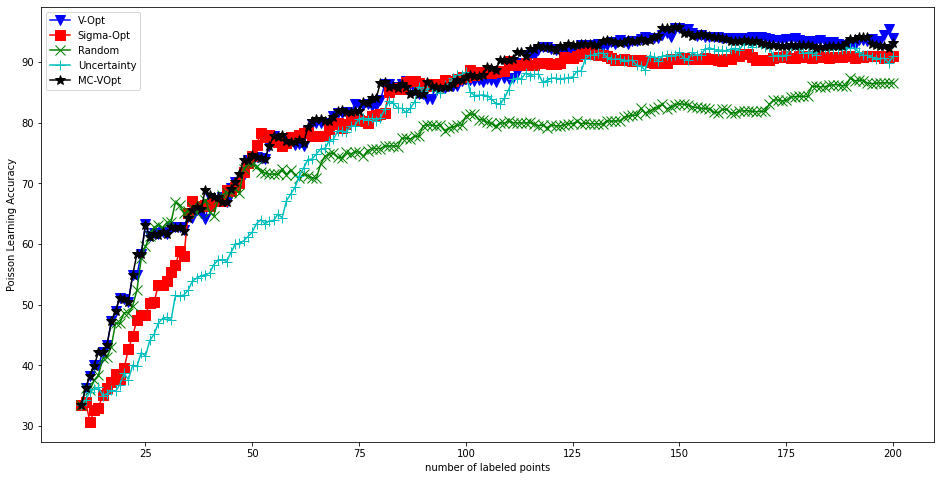

rand: 87.373 unc: 93.111 vopt: 95.688 sopt: 91.638 mc-vopt: 95.851


In [23]:
#1. Raw CNN Output
W = weight_matrix(X)
_, sigmaopt_laplace, sigmaopt_poisson = sigmaopt_simulation(W, labels, 1, 200)
_, mc_vopt_laplace, mc_vopt_poisson = mc_vopt_simulation(W, labels, 1, 200)
_, vopt_laplace, vopt_poisson = vopt_simulation(W, labels, 1, 200)
num_train, random_laplace, random_poisson = random_simulation(W, labels, 1, 200)
_, unc_laplace, unc_poisson = uncertainty_simulation(W, labels, 1, 200)
lineplot(num_train, random_laplace, unc_laplace, vopt_laplace, sigmaopt_laplace, mc_vopt_laplace, 'Laplace', filename='Raw_Laplace')
lineplot(num_train, random_poisson, unc_poisson, vopt_poisson, sigmaopt_poisson, mc_vopt_poisson, 'Poisson', filename='Raw_Poisson')

Total Variation (1175 components):  0.96592176
shape: (6874, 1175)
kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
k=2 connected=False
k=3 connected=False
k=4 connected=False
k=5 connected=False
k=6 connected=False
k=7 connected=False
k=8 connected=True
k=16 connected=True
weight matrix shape:  (6874, 6874)
Sigma-Optimality
0.145476% training data
Number of Labels,Accuracy
Laplace: 10,40.401
Poisson: 10,45.586
0.18318129696502364 1804814.619811382
Number of Labels,Accuracy
Laplace: 11,35.218
Poisson: 11,45.068
0.04459498057317671 981692.7428186612
Number of Labels,Accuracy
Laplace: 12,37.671
Poisson: 12,44.258
0.46553737470134826 608235.5220014536
Number of Labels,Accuracy
Laplace: 13,33.610
Poisson: 13,43.201
0.03121679413718198 407493.0780532716
Number of Labels,Accuracy
Laplace: 14,35.816
Poisson: 14,42.536
7.931410384187013e-06 341844.6830592773
Number of Labels,Accuracy
Laplace: 15,40.195


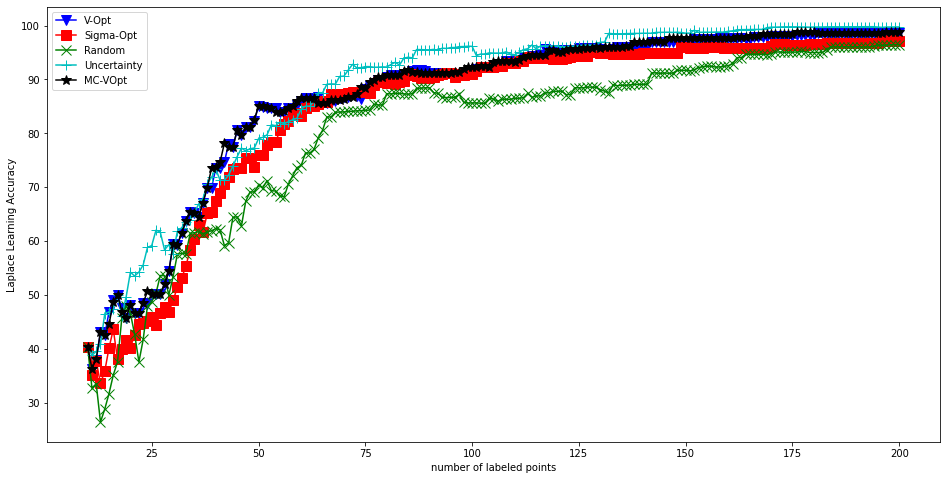

rand: 96.479 unc: 99.791 vopt: 98.653 sopt: 97.274 mc-vopt: 98.772


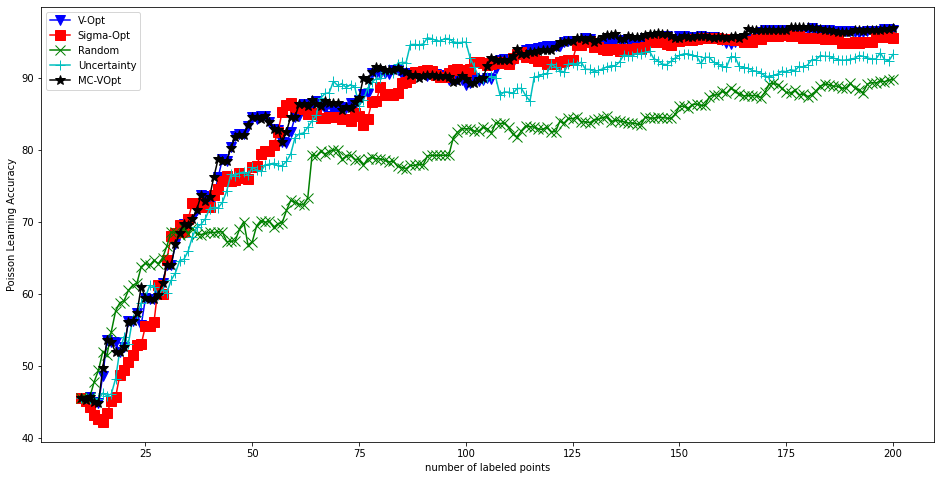

rand: 89.841 unc: 95.607 vopt: 96.937 sopt: 96.032 mc-vopt: 97.148


In [24]:
#2. PCA on CNN output
pca_data = PCA(X)
W = weight_matrix(pca_data)
_, sigmaopt_laplace, sigmaopt_poisson = sigmaopt_simulation(W, labels, 1, 200)
_, mc_vopt_laplace, mc_vopt_poisson = mc_vopt_simulation(W, labels, 1, 200)
_, vopt_laplace, vopt_poisson = vopt_simulation(W, labels, 1, 200)
num_train, random_laplace, random_poisson = random_simulation(W, labels, 1, 200)
_, unc_laplace, unc_poisson = uncertainty_simulation(W, labels, 1, 200)
lineplot(num_train, random_laplace, unc_laplace, vopt_laplace, sigmaopt_laplace, mc_vopt_laplace, 'Laplace', filename='PCA_Laplace')
lineplot(num_train, random_poisson, unc_poisson, vopt_poisson, sigmaopt_poisson, mc_vopt_poisson, 'Poisson', filename='PCA_Poisson')

# CNN VAE

In [25]:
import imageio
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import save_image

to_pil_image = transforms.ToPILImage()

def image_to_vid(images):
    imgs = [np.array(to_pil_image(img)) for img in images]
    imageio.mimsave('generated_images.gif', imgs)

def save_reconstructed_images(recon_images, epoch):
    save_image(recon_images.cpu(), f"output{epoch}.jpg")

def save_loss_plot(train_loss, valid_loss):
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(valid_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss.jpg')
    plt.show()

In [26]:
# Imports
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import Dataset, DataLoader  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
from torch.optim.lr_scheduler import StepLR
import matplotlib
from torchvision.utils import make_grid

matplotlib.style.use('ggplot')

In [27]:
class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

# Loss function (POTENTIALLY CHANGE BCE TO NLL)
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training function
def train(model, dataloader, dataset, device, optimizer, criterion):
    model.train()
    running_loss = 0.0
    counter = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
        counter += 1
        data = data[0]
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()

    train_loss = running_loss / counter 
    return train_loss

# Validation function
def validate(model, dataloader, dataset, device, criterion):
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
            counter += 1
            data = data[0]
            data = data.to(device)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(dataset)/dataloader.batch_size) - 1:
                recon_images = reconstruction

    val_loss = running_loss / counter
    return val_loss, recon_images

In [28]:
kernel_size = 3 # (3, 3) kernel
num_classes = 10
init_channels = 8 # initial number of filters
image_channels = 1
latent_dim = 32 # latent dimension for sampling

# define a Conv VAE
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, 
            stride=1, padding=1
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=1, padding=1
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=1, padding=1
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_channels*4, out_channels=64, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        # fully connected layers for learning representations
        self.fc1 = nn.Linear(64*11*11, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)
        # decoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=64, out_channels=init_channels*8, kernel_size=kernel_size, 
            stride=1, padding=0, output_padding=1, dilation=3
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=0, output_padding=1, dilation=3
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1, output_padding=1, dilation=1
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size, 
            stride=2, padding=1, output_padding=1, dilation=1
        )
        self.droupout1 = nn.Dropout(0.5)

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
 
    def forward(self, x): #88
        # encoding
        x = F.relu(self.enc1(x)) #88
        x = F.max_pool2d(x, 2) #44
        x = F.relu(self.enc2(x)) #44
        x = F.max_pool2d(x, 2) #22
        x = F.relu(self.enc3(x)) #22
        x = F.relu(self.enc4(x)) #11
        batch, _, _, _ = x.shape
        x = self.droupout1(x)
        x = x.reshape(batch, -1)
        hidden = self.fc1(x) #(64*11*11, 128)
        # get `mu` and `log_var`
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var) #(64, 16)
        z = self.fc2(z) #(64, 64)
        z = z.view(-1, 64, 1, 1)
 
        # decoding
        x = F.relu(self.dec1(z)) #8
        x = F.relu(self.dec2(x)) #22
        x = self.droupout1(x)
        x = F.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))
        return reconstruction, mu, log_var

    def encode(self, x):
        x = F.relu(self.enc1(x)) #88
        x = F.max_pool2d(x, 2) #44
        x = F.relu(self.enc2(x)) #44
        x = F.max_pool2d(x, 2) #22
        x = F.relu(self.enc3(x)) #22
        x = F.relu(self.enc4(x)) #11
        x = self.droupout1(x)
        x = x.reshape(x.shape[0], -1)
        return x

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# initialize the model
model = ConvVAE().to(device)

# set the learning parameters
lr = 0.001
epochs = 50
batch_size = 64
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

cuda = True
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

# a list to save all the reconstructed images in PyTorch grid format
grid_images = []

In [30]:
#Convert targets to numerical labels
target = hdr[:,0].tolist()
classes = set(target)
label_dict = dict(zip(classes, np.arange(len(classes))))
labels = np.array([label_dict[t] for t in target],dtype=int)

#Training and testing split (based on papers)
angle = hdr[:,6].astype(int)
train_idx = angle == 17
test_idx = angle == 15

#Train testing split and convert to torch
data = torch.from_numpy(np.reshape(mag,(mag.shape[0],1,mag.shape[1],mag.shape[2]))).float()
#data = data / torch.max(data)
labels = torch.from_numpy(labels).long()
data_train = data[train_idx,:,:,:]
data_test = data[test_idx,:,:,:]
target_train = labels[train_idx]
target_test = labels[test_idx]

#Randomly shuffle training data
P = torch.randperm(np.sum(train_idx))
data_train = data_train[P,:,:,:]
target_train = target_train[P]

#Convert to torch dataloaders
dTr = data_train
dV = data_test
tTr = target_train
tV = target_test

SAR_train = MyDataset(dTr, tTr) 
trainloader = DataLoader(SAR_train, batch_size = batch_size, shuffle = True, **kwargs)

SAR_validate = MyDataset(dV, tV) 
testloader = DataLoader(SAR_validate, batch_size = batch_size, shuffle = True, **kwargs)

Epoch 1 of 50


58it [00:01, 51.68it/s]
51it [00:00, 128.25it/s]                        


Train Loss: 314268.6794
Val Loss: 181562.1458
Epoch 2 of 50


58it [00:00, 61.24it/s]                        
51it [00:00, 126.45it/s]                        


Train Loss: 158565.1256
Val Loss: 130327.4618
Epoch 3 of 50


58it [00:00, 61.91it/s]                        
51it [00:00, 126.73it/s]                        


Train Loss: 125895.1518
Val Loss: 105894.8838
Epoch 4 of 50


58it [00:00, 61.83it/s]                        
51it [00:00, 129.24it/s]                        


Train Loss: 112208.4969
Val Loss: 100500.1641
Epoch 5 of 50


58it [00:00, 60.44it/s]                        
51it [00:00, 125.29it/s]                        


Train Loss: 109597.0098
Val Loss: 99277.0781
Epoch 6 of 50


58it [00:00, 59.70it/s]                        
51it [00:00, 129.04it/s]                        


Train Loss: 108572.7773
Val Loss: 98673.1970
Epoch 7 of 50


58it [00:00, 61.06it/s]                        
51it [00:00, 127.35it/s]                        


Train Loss: 108072.1741
Val Loss: 98299.0261
Epoch 8 of 50


58it [00:00, 60.28it/s]                        
51it [00:00, 129.38it/s]                        


Train Loss: 107779.3964
Val Loss: 98204.0783
Epoch 9 of 50


58it [00:00, 60.35it/s]                        
51it [00:00, 125.82it/s]                        


Train Loss: 107559.8032
Val Loss: 98015.3872
Epoch 10 of 50


58it [00:00, 60.83it/s]                        
51it [00:00, 126.08it/s]                        


Train Loss: 107391.9982
Val Loss: 97881.6809
Epoch 11 of 50


58it [00:00, 60.85it/s]                        
51it [00:00, 127.86it/s]                        


Train Loss: 107285.1597
Val Loss: 97929.1351
Epoch 12 of 50


58it [00:00, 60.17it/s]                        
51it [00:00, 126.49it/s]                        


Train Loss: 107170.7634
Val Loss: 97825.4476
Epoch 13 of 50


58it [00:00, 60.32it/s]                        
51it [00:00, 129.36it/s]                        


Train Loss: 107034.9153
Val Loss: 97628.6237
Epoch 14 of 50


58it [00:00, 61.71it/s]                        
51it [00:00, 128.31it/s]                        


Train Loss: 106929.1445
Val Loss: 97701.7781
Epoch 15 of 50


58it [00:00, 61.31it/s]                        
51it [00:00, 126.65it/s]                        


Train Loss: 106855.4276
Val Loss: 97541.1768
Epoch 16 of 50


58it [00:00, 61.49it/s]                        
51it [00:00, 128.27it/s]                        


Train Loss: 106748.9182
Val Loss: 97468.6128
Epoch 17 of 50


58it [00:00, 61.64it/s]                        
51it [00:00, 130.87it/s]                        


Train Loss: 106716.6507
Val Loss: 97487.3279
Epoch 18 of 50


58it [00:00, 61.59it/s]                        
51it [00:00, 124.08it/s]                        

Train Loss: 106623.3270
Val Loss: 97451.0850
Epoch 19 of 50



58it [00:00, 60.94it/s]                        
51it [00:00, 130.64it/s]                        


Train Loss: 106548.0562
Val Loss: 97392.1695
Epoch 20 of 50


58it [00:00, 61.78it/s]                        
51it [00:00, 129.82it/s]                        


Train Loss: 106504.5490
Val Loss: 97423.4733
Epoch 21 of 50


58it [00:00, 61.74it/s]                        
51it [00:00, 130.32it/s]                        


Train Loss: 106428.1045
Val Loss: 97294.5537
Epoch 22 of 50


58it [00:00, 61.82it/s]                        
51it [00:00, 128.28it/s]                        


Train Loss: 106378.1431
Val Loss: 97382.1255
Epoch 23 of 50


58it [00:00, 61.21it/s]                        
51it [00:00, 130.63it/s]                        


Train Loss: 106312.0942
Val Loss: 97239.6454
Epoch 24 of 50


58it [00:00, 61.26it/s]                        
51it [00:00, 124.60it/s]                        

Train Loss: 106265.7022
Val Loss: 97445.1283
Epoch 25 of 50



58it [00:00, 62.54it/s]                        
51it [00:00, 130.47it/s]                        


Train Loss: 106193.7431
Val Loss: 97386.9451
Epoch 26 of 50


58it [00:00, 61.21it/s]                        
51it [00:00, 131.41it/s]                        


Train Loss: 106087.0372
Val Loss: 97470.7581
Epoch 27 of 50


58it [00:00, 61.59it/s]                        
51it [00:00, 124.68it/s]                        

Train Loss: 105987.5133
Val Loss: 97373.1260
Epoch 28 of 50



58it [00:00, 60.39it/s]                        
51it [00:00, 127.72it/s]                        


Train Loss: 105888.3790
Val Loss: 97378.4209
Epoch 29 of 50


58it [00:00, 60.04it/s]                        
51it [00:00, 128.00it/s]                        


Train Loss: 105807.7437
Val Loss: 97324.4421
Epoch 30 of 50


58it [00:00, 60.88it/s]                        
51it [00:00, 124.59it/s]                        

Train Loss: 105758.2330
Val Loss: 97314.6013
Epoch 31 of 50



58it [00:00, 60.64it/s]                        
51it [00:00, 126.09it/s]                        

Train Loss: 105696.9912
Val Loss: 97270.2321
Epoch 32 of 50



58it [00:00, 60.57it/s]                        
51it [00:00, 128.38it/s]                        


Train Loss: 105663.9196
Val Loss: 97424.4751
Epoch 33 of 50


58it [00:00, 60.22it/s]                        
51it [00:00, 127.86it/s]                        


Train Loss: 105614.3055
Val Loss: 97465.8846
Epoch 34 of 50


58it [00:00, 60.98it/s]                        
51it [00:00, 125.84it/s]                        

Train Loss: 105588.9972
Val Loss: 97391.8584
Epoch 35 of 50



58it [00:00, 59.51it/s]                        
51it [00:00, 126.41it/s]                        


Train Loss: 105546.5564
Val Loss: 97368.8047
Epoch 36 of 50


58it [00:00, 60.92it/s]                        
51it [00:00, 127.47it/s]                        


Train Loss: 105501.0736
Val Loss: 97345.8778
Epoch 37 of 50


58it [00:00, 59.94it/s]                        
51it [00:00, 129.16it/s]                        


Train Loss: 105471.6192
Val Loss: 97308.4072
Epoch 38 of 50


58it [00:00, 59.58it/s]                        
51it [00:00, 128.61it/s]                        


Train Loss: 105416.7126
Val Loss: 97206.5534
Epoch 39 of 50


58it [00:00, 60.87it/s]                        
51it [00:00, 126.31it/s]                        


Train Loss: 105395.4058
Val Loss: 97323.7671
Epoch 40 of 50


58it [00:00, 60.62it/s]                        
51it [00:00, 127.80it/s]                        


Train Loss: 105351.8209
Val Loss: 97159.6830
Epoch 41 of 50


58it [00:00, 60.75it/s]                        
51it [00:00, 128.71it/s]                        


Train Loss: 105337.4342
Val Loss: 97122.4492
Epoch 42 of 50


58it [00:00, 60.90it/s]                        
51it [00:00, 128.14it/s]                        


Train Loss: 105310.2119
Val Loss: 97172.2737
Epoch 43 of 50


58it [00:00, 61.10it/s]                        
51it [00:00, 126.96it/s]                        


Train Loss: 105272.6746
Val Loss: 97028.6186
Epoch 44 of 50


58it [00:00, 61.04it/s]                        
51it [00:00, 131.59it/s]                        


Train Loss: 105232.4630
Val Loss: 97033.5287
Epoch 45 of 50


58it [00:00, 62.84it/s]                        
51it [00:00, 129.82it/s]                        


Train Loss: 105188.0594
Val Loss: 96993.9818
Epoch 46 of 50


58it [00:00, 61.94it/s]                        
51it [00:00, 130.45it/s]                        


Train Loss: 105143.9694
Val Loss: 96976.1994
Epoch 47 of 50


58it [00:00, 61.74it/s]                        
51it [00:00, 130.82it/s]                        


Train Loss: 105117.7892
Val Loss: 96926.4049
Epoch 48 of 50


58it [00:00, 62.59it/s]                        
51it [00:00, 135.17it/s]                        


Train Loss: 105020.4643
Val Loss: 96826.8869
Epoch 49 of 50


58it [00:00, 61.31it/s]                        
51it [00:00, 128.38it/s]                        


Train Loss: 104908.7607
Val Loss: 96630.7194
Epoch 50 of 50


58it [00:00, 61.62it/s]                        
51it [00:00, 125.82it/s]                        


Train Loss: 104755.1521
Val Loss: 96478.8867


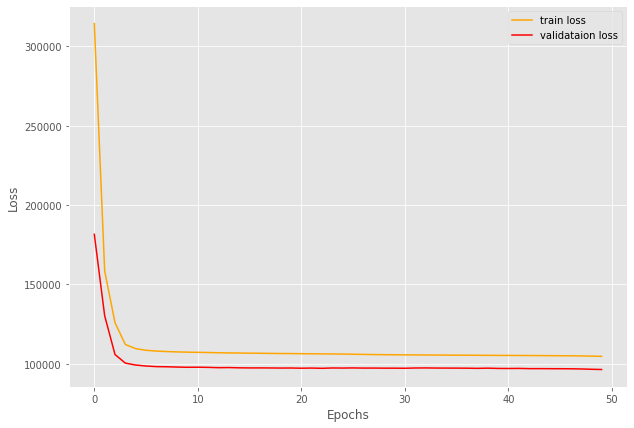

TRAINING COMPLETE


In [31]:
train_loss = []
valid_loss = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")

    train_epoch_loss = train(
        model, trainloader, SAR_train, device, optimizer, criterion
    )
    valid_epoch_loss, recon_images = validate(
        model, testloader, SAR_validate, device, criterion
    )

    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)

    # save the reconstructed images from the validation loop
    save_reconstructed_images(recon_images, epoch+1)

    # convert the reconstructed images to PyTorch image grid format
    image_grid = make_grid(recon_images.detach().cpu())
    grid_images.append(image_grid)

    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")

# save the reconstructions as a .gif file
image_to_vid(grid_images)

# save the loss plots to disk
save_loss_plot(train_loss, valid_loss)
print('TRAINING COMPLETE')

In [32]:
#Save model
torch.save(model.state_dict(), 'SAR10_cvae.pt')

CVAE_data = data

#Encode the dataset and save to npz file
with torch.no_grad():
    mu = model.encode(CVAE_data.to(device))
    Y = mu.cpu().numpy()
    np.savez_compressed('SAR10_cvae.npz',data=Y,labels=labels)

In [33]:
# W_raw = weight_matrix(X)
# M = np.load('SAR10_cvae.npz')
# cvae_data = M['data']
# labels = M['labels']
# W_cvae = weight_matrix(cvae_data)

# #Randomly choose training datapoints (use a stored permutation to be consistent)
# np.random.seed(0)
# train_ind = gl.randomize_labels(labels, 50)
# np.random.seed()
# train_idx = angle == 17
# train_labels = labels[train_idx]

# #Run Laplace and Poisson learning
# labels_raw = gl.graph_ssl(W_raw,train_idx,train_labels,algorithm='laplace')
# labels_vae = gl.graph_ssl(W_cvae,train_idx,train_labels,algorithm='laplace')

# #Print accuracy
# print('Using %d labels per class'%int(len(train_ind)/10))
# print('Accuracy using raw pixel values: %.2f'%gl.accuracy(labels_raw,labels,len(train_ind)))
# print('Accuracy using CVAE: %.2f'%gl.accuracy(labels_vae,labels,len(train_ind)))

(6874, 7744)
kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
k=2 connected=False
k=3 connected=False
k=4 connected=False
k=5 connected=False
k=6 connected=False
k=7 connected=False
k=8 connected=False
k=9 connected=False
k=10 connected=False
k=11 connected=True
k=22 connected=True
weight matrix shape:  (6874, 6874)
Sigma-Optimality
0.145476% training data
Number of Labels,Accuracy
Laplace: 10,21.140
Poisson: 10,23.208
0.7025495341349776 1178203.0324780657
Number of Labels,Accuracy
Laplace: 11,25.776
Poisson: 11,26.752
0.034395126579205536 340775.17674849613
Number of Labels,Accuracy
Laplace: 12,29.627
Poisson: 12,25.896
0.25062623461836925 168711.24995736606
Number of Labels,Accuracy
Laplace: 13,30.098
Poisson: 13,26.017
0.009998405506933046 96943.86591936254
Number of Labels,Accuracy
Laplace: 14,28.032
Poisson: 14,25.933
0.002913829550525336 80037.1072673087
Number of Labels,Accuracy
Laplace: 

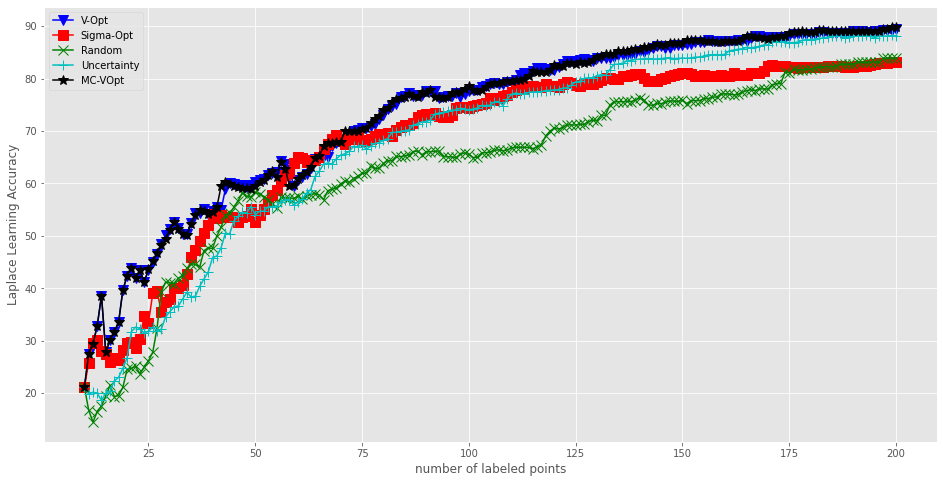

rand: 83.910 unc: 88.210 vopt: 89.362 sopt: 83.144 mc-vopt: 89.886


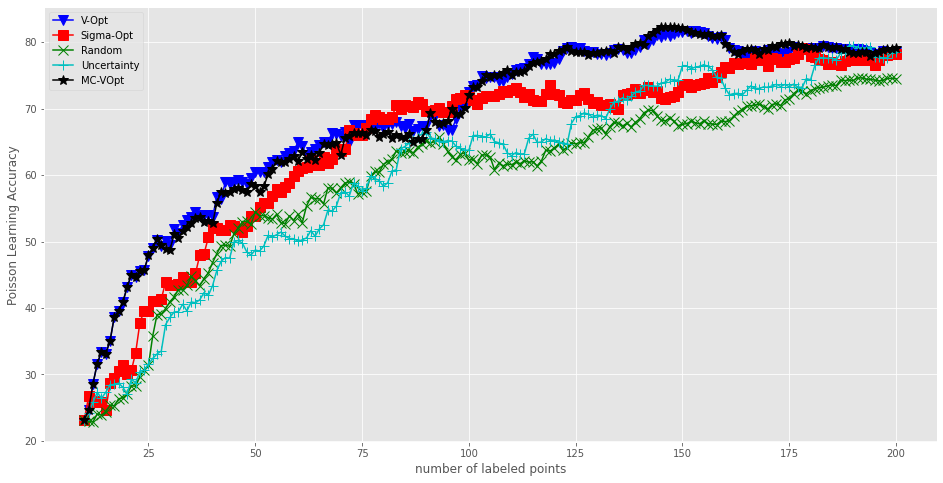

rand: 74.618 unc: 79.476 vopt: 81.625 sopt: 79.152 mc-vopt: 82.315


In [34]:
#3. CVAE
M = np.load('SAR10_cvae.npz')
cvae_data = M['data']
print(cvae_data.shape)
labels = M['labels']
W = weight_matrix(cvae_data)
_, sigmaopt_laplace, sigmaopt_poisson = sigmaopt_simulation(W, labels, 1, 200)
_, mc_vopt_laplace, mc_vopt_poisson = mc_vopt_simulation(W, labels, 1, 200)
_, vopt_laplace, vopt_poisson = vopt_simulation(W, labels, 1, 200)
num_train, random_laplace, random_poisson = random_simulation(W, labels, 1, 200)
_, unc_laplace, unc_poisson = uncertainty_simulation(W, labels, 1, 200)
lineplot(num_train, random_laplace, unc_laplace, vopt_laplace, sigmaopt_laplace, mc_vopt_laplace, 'Laplace', filename='CVAE_Laplace_Results')
lineplot(num_train, random_poisson, unc_poisson, vopt_poisson, sigmaopt_poisson, mc_vopt_poisson, 'Poisson', filename='CVAE_Poisson_Results')